# Self-Study: Algebraic Connectivty and Community Detection

## Section 1: Algebraic Connectivity

Write a function `algebraic_connectivity(adj_matrix)` that returns the second-smallest eigenvalue of the combinatorial Laplacian. Use only routines from `np.linalg` (no SciPy shortcuts).

### Task 1
1. Derive the combinatorial Laplacian $L = D - A$ from an adjacency matrix.
2. Implement `algebraic_connectivity(adj_matrix)` using `np.linalg`.
3. Compute the algebraic connectivity for the two example networks generated below.

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy import diag

In [31]:
def algebraic_connectivity(adj_matrix: np.ndarray) -> float:
    """Compute the algebraic connectivity (Fiedler value) of a simple graph."""
    A = adj_matrix
    K = diag(np.sum(A, axis=1))
    L = K - A
    
    eigenvalues = np.linalg.eigvalsh(L)
    eigenvalues.sort()
    return eigenvalues[1]
    
    pass

In [32]:
# CODE PROVIDED

def lattice_adjacency(n_rows: int, n_cols: int) -> np.ndarray:
    """Return the adjacency matrix of a 2D lattice graph with free boundaries."""
    grid = nx.grid_2d_graph(n_rows, n_cols)
    mapping = {node: idx for idx, node in enumerate(grid.nodes())}
    relabelled = nx.relabel_nodes(grid, mapping)
    return nx.to_numpy_array(relabelled)


def ring_of_cliques_adjacency(clique_size: int = 5, n_cliques: int = 4) -> np.ndarray:
    """Return four cliques connected in a ring by single bridging edges."""
    cliques = [nx.complete_graph(clique_size) for _ in range(n_cliques)]
    ring = nx.disjoint_union_all(cliques)
    offsets = [i * clique_size for i in range(n_cliques)]
    for i in range(n_cliques):
        ring.add_edge(offsets[i], offsets[(i + 1) % n_cliques])
    return nx.to_numpy_array(ring)


def plot_graph(
    adj_matrix: np.ndarray,
    node_colors=None,
) -> None:
    """Draw the network defined by adj_matrix using a configurable layout."""
    graph = nx.from_numpy_array(adj_matrix)

    pos = nx.spring_layout(graph, seed=42)

    if node_colors is None:
        node_colors = "#1f78b4"
    else:
        node_colors = list(np.asarray(node_colors).ravel())

    plt.figure(figsize=(5, 5))
    nx.draw_networkx(
        graph,
        pos=pos,
        node_size=200,
        node_color=node_colors,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def plot_partitioned_graph(
    adj_matrix: np.ndarray,
    labels: np.ndarray,
) -> None:
    """Visualise a two-way partition by colouring nodes via labels (0/1)."""
    labels = np.asarray(labels, dtype=int)
    colors = np.array(["#1f77b4", "#ff7f0e"])
    print(colors)
    node_colors = colors[labels]
    plot_graph(adj_matrix, node_colors=node_colors)

The two graphs you will be looking at are

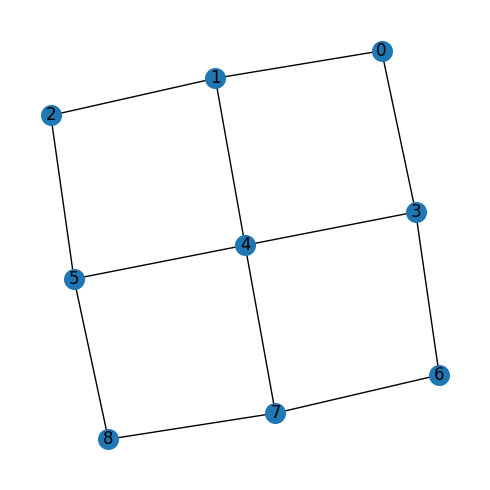

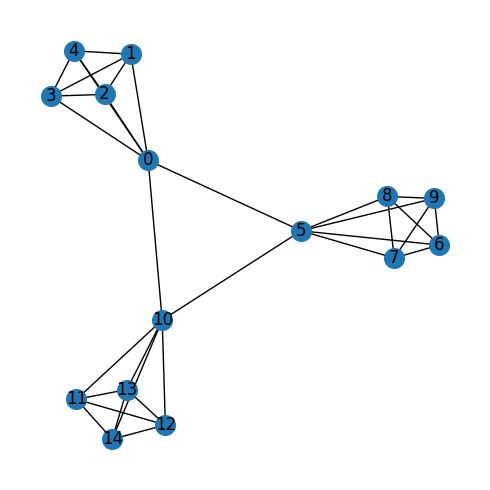

In [33]:
plot_graph(lattice_adjacency(3, 3))
plot_graph(ring_of_cliques_adjacency(5, 3))

In [34]:
print("Algebraic connectivity of 3x3 lattice:", algebraic_connectivity(lattice_adjacency(3, 3)))
print("Algebric connectivity of ring of cliques:", algebraic_connectivity(ring_of_cliques_adjacency(5, 3)))

Algebraic connectivity of 3x3 lattice: 0.9999999999999997
Algebric connectivity of ring of cliques: 0.3944487245360093


In [35]:
def fiedler_vector(adj_matrix: np.ndarray):
    """Compute the Fiedler vector of a simple graph."""
    A = adj_matrix
    K = diag(np.sum(A, axis=1))
    L = K - A
    
    #print("Laplacian matrix:\n", L)
    eigenvalues, eigenvectors = np.linalg.eig(L)
    
    R_quotient_values = {}
    
    for v in eigenvectors:
        R_quotient = (v.T @ L @ v) / (v.T @ v)
        R_quotient_values[R_quotient] = v
    
    # Sort by R_quotient values
    R_quotient_values = dict(sorted(R_quotient_values.items()))
    # The second smallest R_quotient corresponds to the Fiedler vector
    fiedler_vector = list(R_quotient_values.values())[1]    
    return fiedler_vector

In [36]:
fielder_vector = fiedler_vector(ring_of_cliques_adjacency(5, 3))
print("Fiedler vector of ring of cliques:\n\n", fielder_vector)

Fiedler vector of ring of cliques:

 [-3.90731184e-01 -2.58198890e-01 -1.18303883e-01 -1.41683937e-01
 -6.54094477e-01  3.37179843e-01  2.01213928e-01 -4.27247154e-04
 -1.21118824e-02  1.19244067e-02 -5.18147820e-02 -1.22255193e-03
 -6.24690463e-03  1.32014748e-02  1.72076853e-02]


### Task 2

Compute the algebraic connectivity (Fiedler value) for `ring_of_cliques_adjacency` with a fixed number of cliques (4), but varying the size of each clique from 3 to 10.

Plot the algebraic connectivity as a function of clique size. What trend do you observe? How does increasing clique density affect the connectivity of the overall graph?

Text(0, 0.5, 'Algebraic Connectivity')

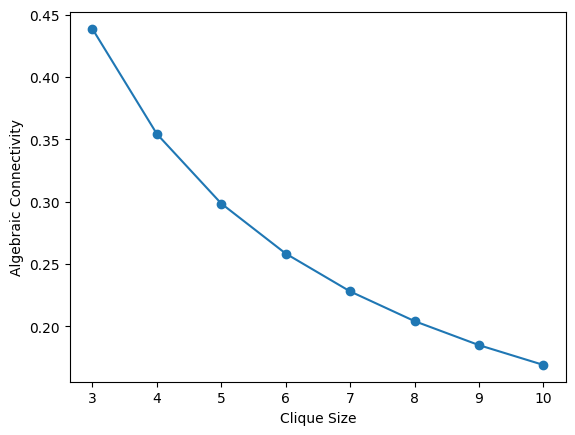

In [37]:
clique_sizes = range(3, 11)
fiedler_values = [algebraic_connectivity(ring_of_cliques_adjacency(clique_size=size)) for size in clique_sizes]
plt.plot(clique_sizes, fiedler_values, marker='o')
plt.xlabel("Clique Size")
plt.ylabel("Algebraic Connectivity")

## Section 2: Bisection

### Task 3: Spectral Bisection
1. Use the Fiedler vector returned by `fiedler_vector` to split the ring-of-cliques graph into two communities.
2. Visualise the partition by colouring the nodes according to their community membership, see `plot_partitioned_graph`
3. Explain how the cut produced by the Fiedler vector relates to the graph's weakest links.

In [38]:
#spectral bisection algorithm (taken from lecture notes)

def spectral_bisection(A):
    K = diag(np.sum(A, axis=1))
    
    w2 = fiedler_vector(A)
    Spos = []
    
    for i in range(A.shape[0]):
        if w2[i] > 0:
            Spos.append(i)
    Sneg = [i for i in range(A.shape[0]) if i not in Spos]
    
    return Spos, Sneg

def recursive_spectral(A, depth=0, max_depth=2, community_index=0, labels=None):
    """Recursively partition the graph and assign community labels."""
    if labels is None:
        labels = np.full(A.shape[0], -1, dtype=int)  # Initialize all nodes with -1 (unassigned)

    if depth == max_depth or len(A) <= 3:
        # Assign the current community index to all nodes in this partition
        labels[:len(A)] = community_index
        return labels

    Spos, Sneg = spectral_bisection(A)

    # Recursively partition the positive and negative subsets
    labels[Spos] = community_index
    labels[Sneg] = community_index + 1

    labels = recursive_spectral(A[np.ix_(Spos, Spos)], depth + 1, max_depth, community_index, labels)
    labels = recursive_spectral(A[np.ix_(Sneg, Sneg)], depth + 1, max_depth, community_index + 1, labels)

    return labels

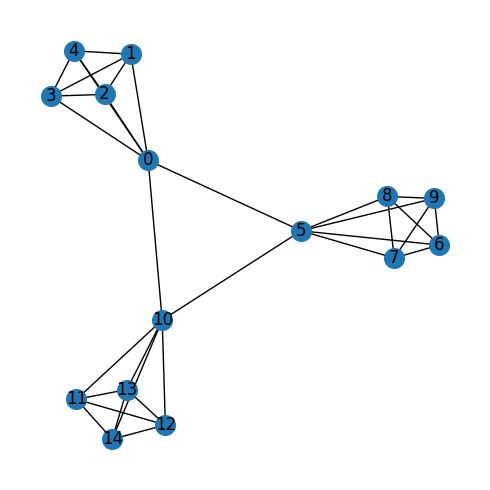

['#1f77b4' '#ff7f0e']


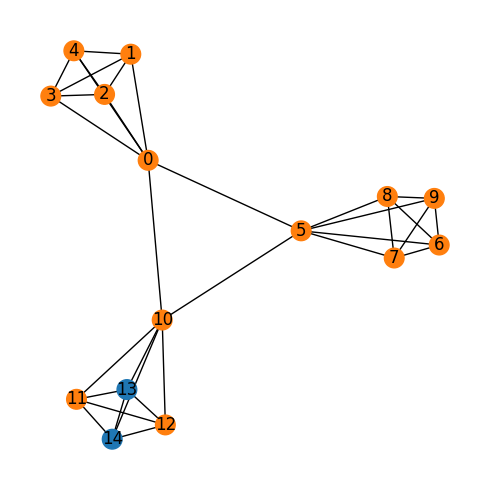

In [39]:
plot_graph(ring_of_cliques_adjacency(5, 3))
# Use recursive_spectral to divide the graph into two communities
adj_matrix = ring_of_cliques_adjacency(5, 3)
labels = recursive_spectral(adj_matrix, max_depth= 1)  # Set max_depth=2 for four communities

# Visualize the partition
plot_partitioned_graph(adj_matrix, labels)

The cut minimizes the connections between the two groups, effectively splitting the graph along its weakest links. In the "ring of cliques" graph, the weakest links are the single edges connecting different cliques.
These edges are less dense compared to the internal connections within each clique, making them natural candidates for separation. 